# Scraping play-by-play data from stats.nba.com

We define two methods, one using BeautifulSoup and the other using the stats.nba.com API (via http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/).

We use the API method.

The BeautifulSoup method is preserved for reference.

We use the EVENTMSGTYPE column because it encodes the action information. See DOCS.md for details.

## Method 2 - with stats.nba.com API

In [148]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display

# dont hide columns when displaying dataframe
pd.set_option('display.max_columns', None)

## Get the data

In [141]:
# get playbyplay data
# needs an internet connection

playbyplay_url = 'http://stats.nba.com/stats/playbyplayv2?EndPeriod=10&EndRange=55800&GameID=0041500314&RangeType=2&Season=2015-16&SeasonType=Playoffs&StartPeriod=1&StartRange=0'

# request the URL and parse the JSON
response = requests.get(playbyplay_url)
response.raise_for_status() # raise exception if invalid response
header = response.json()['resultSets'][0]['headers']
plays = response.json()['resultSets'][0]['rowSet']

# get the playbyplay data in a dataframe
df_raw = pd.DataFrame(shots, columns=header)

## Pre-processing data (including handling missing data)

In [215]:
# propagate score so that every table has the appropriate score

# set first score to 0-0
df_raw.set_value(0,'SCORE',"0 - 0")
# forward-propagate
df_raw.SCORE.fillna(method='ffill', inplace=True)


# regularize eventnum (sometimes jumps a few)
# make it match df line
df_raw['EVENTNUM'] = pd.Series(df.index)

# create final dataframe with relevant information only

relevant_columns = ["EVENTNUM", "EVENTMSGTYPE", "EVENTMSGACTIONTYPE"]
df = df_raw[relevant_columns]

## Create one-hot encoded event vectors
Example: if one event is EVENTNUM=2, then it will be represented by the vector v=[0 0 1 0 0 0  ... 0]

In [158]:
# define event_to_OHE function

def event_to_OHE(event_code, size):
    """
    converts event_code to a One-Hot Encoded (OHE) vector of lenght size
    
    Input:
        event_code (int): the event code
        size (int): the lenght of the final OHE vector
    
    Output:
        event_OHE (ndarray): OHE vector
    
    Dependencies:
        numpy as np
    
    Comments:
        enforces event_code to be smaller than size.
        expecting 0 to be a valid event_code
        
    Examples:
        event_to_OHE(3, 5) = np.array([0,0,0,1,0])
        event_to_OHE(1, 2) = np.array([0,1])
    """
    assert event_code < size
    
    vec = np.zeros(size)
    vec[event_code] = 1.
    
    return vec

assert np.array_equal(event_to_OHE(4,5), np.array([0,0,0,0,1]))
assert np.array_equal(event_to_OHE(1,10), np.array([0,1,0,0,0,0,0,0,0,0]))
assert np.array_equal(event_to_OHE(0,2), np.array([1,0]))

In [229]:
# get timeout events ID: those that match EVENTMSGTYPE=9

timeout_events_df = df[(df.EVENTMSGTYPE==9) & ((df.EVENTMSGACTIONTYPE==1) | (df.EVENTMSGACTIONTYPE==2))]
timeout_events = list(timeout_events_df["EVENTNUM"])
num_timeout_events = len(timeout_events)
timeout_events

[47, 60, 99, 142, 195, 225, 274, 307, 330, 372, 431, 467, 483]

In [230]:
# create OHE df

num_features = max(df.EVENTMSGTYPE) + 1 # account for EVENTMSGTYPE=0
df_ohe = pd.DataFrame([event_to_OHE(x, num_features) for x in df.EVENTMSGTYPE])

In [236]:
# create design matrix X by summing over K events before timeout

K = 10

X = np.zeros((num_timeout_events, num_features))

idx=0
for timeout_id in timeout_events:
    before_events = df_ohe.iloc[timeout_id-10:timeout_id]
    X[idx,:] = sum(before_events)
    idx+=1

In [243]:
# create labels

y = ones(num_timeout_events)

Probably what we want to do is not to select only the timeouts, but to run a sort of window through all the events and populate a label vector with whether it was a timeout or not

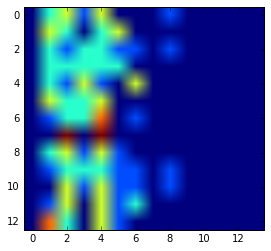

In [244]:
## Visualizing X

plt.imshow(X)

## Learning

Model 1 - Linear regression

In [245]:
from sklearn.linear_model import LinearRegression

# standardize features
X

# fit model

# cross val

array([[ 0.,  2.,  3.,  1.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  3.,  2.,  0.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  2.,  1.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  2.,  1.,  3.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  3.,  2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  2.,  2.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  5.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  2.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  2.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  3.,  1.,  3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  3.,  0.,  3.,  1.,  2., 

# Reference code

Not used

## Method 1 - with BeautifulSoup
Not used


In [38]:
# get all the info in the website, via inspecting the html code
# not used 

from bs4 import BeautifulSoup
import requests

import pandas as pd

url = "http://stats.nba.com/game/#!/0041500314/playbyplay/"
r  = requests.get(url)

data = r.text
soup = BeautifulSoup(data)
#print(soup.prettify())

table = soup.find('table', attrs={'class': "table"})
#print(table)


rows = table.findAll('tr')
for tr in rows:
    cols = tr.findAll('td')
    for td in cols:
        text = td.find(text=True) + ';'
#        print (text)


/Users/joaopcoelho/anaconda/envs/python3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


In [30]:
# timeouts baby

df_home  = df[df.HOMEDESCRIPTION.notnull()]
df_home_timeouts=df_home[df_home.HOMEDESCRIPTION.str.contains("Timeout")]

df_away  = df[df.VISITORDESCRIPTION.notnull()]
df_away_timeouts=df_away[df_away.VISITORDESCRIPTION.str.contains("Timeout")]

In [31]:
total_timeouts = pd.concat([df_home_timeouts, df_away_timeouts])

In [107]:
total_timeouts.sort_values(by="EVENTNUM")[["EVENTMSGTYPE", "HOMEDESCRIPTION", "VISITORDESCRIPTION", "SCORE"]]

,EVENTMSGTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,SCORE
47,9,None,Warriors Timeout: Regular (Reg.1 Short 0),8 - 15
60,9,None,Warriors Timeout: Short (Reg.1 Short 1),8 - 22
99,9,THUNDER Timeout: Regular (Full 1 Short 0),None,19 - 28
142,9,THUNDER Timeout: Regular (Full 2 Short 0),None,30 - 32
195,9,None,Warriors Timeout: Regular (Reg.2 Short 1),40 - 47
225,9,None,Warriors Timeout: Regular (Reg.3 Short 1),43 - 56
274,9,THUNDER Timeout: Short (Full 2 Short 1),None,50 - 69
307,9,THUNDER Timeout: Regular (Full 3 Short 1),None,55 - 72
330,9,THUNDER Timeout: Short (Full 3 Short 2),None,65 - 76
372,9,None,Warriors Timeout: Regular (Reg.4 Short 1),74 - 84


In [120]:
# Explore data
# fields to explore: EVENTMSGACTIONTYPE, EVENTMSGTYPE

field_to_explore = "EVENTMSGTYPE"
fields_to_show = [field_to_explore] + ["EVENTMSGACTIONTYPE", "HOMEDESCRIPTION", "NEUTRALDESCRIPTION", "VISITORDESCRIPTION"]

a = df[fields_to_show]

max_ = df[field_to_explore].max()

from ipywidgets import interact

n=1
@interact(emat = (0,int(max_)))
def show_df(emat=n):
    display(a[a[field_to_explore] == emat])


,EVENTMSGTYPE,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION


In [ ]:
#df[df.HOMEDESCRIPTION.str.contains("Jump", na=False)]
